In [35]:
import yfinance as yf
import pandas as pd
import os


In [36]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [42]:
sp500.index = pd.to_datetime(sp500.index)

In [49]:
# filter dates to only inlcude after 1990-01-01
filter_date = pd.Timestamp('1990-01-01', tz='UTC').tz_convert('US/Eastern')
sp500 = sp500[sp500.index >= filter_date]


<AxesSubplot:xlabel='Date'>

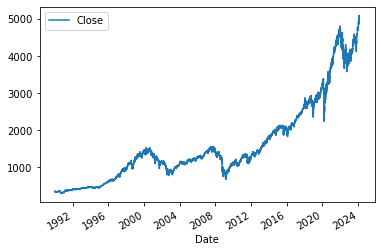

In [52]:
# plot data to see historical closing prices
sp500.plot.line(y="Close", use_index=True)

In [50]:
# delete unwanted columns
del sp500["Dividends"]
del sp500["Stock Splits"]

In [51]:
# create column for tomorrow's price
sp500["Tomorrow"] = sp500["Close"].shift(-1)

# create target, is tomorrow price greater than today's price, creating as integer
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

/var/folders/s3/_hbrgswx2k72nw__rm8cnm780000gn/T/ipykernel_46439/3816891677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Tomorrow"] = sp500["Close"].shift(-1)
/var/folders/s3/_hbrgswx2k72nw__rm8cnm780000gn/T/ipykernel_46439/3816891677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)


,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-02-21 00:00:00-05:00,4963.029785,4983.209961,4946.000000,4981.799805,3788390000,5087.029785,1
2024-02-22 00:00:00-05:00,5038.830078,5094.390137,5038.830078,5087.029785,4051710000,5088.799805,1
2024-02-23 00:00:00-05:00,5100.919922,5111.060059,5081.459961,5088.799805,3672790000,5069.529785,0
